In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle as pk
import matplotlib.pyplot as plt
import json
from glob import glob

# Definições iniciais

## Initializing Constants

In [2]:
# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]
ini_cond_var = constant_properties["ini_cond_var"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]

## Reading results file

In [3]:
def get_infection_site(struct_name):

    center_str = (struct_name).split("__")[-2].split("(")[-1].split(")")[0].split(",")

    center = (float(center_str[0]), float(center_str[1]))

    radius = float(struct_name.split("__")[-1].split("--")[-1].split(".pkl")[0])

    return center, radius


def read_files(path):
    file_list = sorted(glob(path + "/*"))

    speed_up_list = []
    Cb_list = []
    Cn_list = []

    for file in file_list:

        variable = lambda a: a.split("/")[-1].split("__")[0]

        if variable(file) == "Cl":
            Cn_list.append(file)

        elif variable(file) == "Cp":
            Cb_list.append(file)

        elif variable(file) == "speed_up":
            speed_up_list.append(file)

    return Cn_list, Cb_list, speed_up_list


def change_dim_order(np_array):
    # (2, 2, 100001, 21, 21)
    sim_shape = np_array.shape

    form_array = np.zeros(
        (
            sim_shape[2],
            sim_shape[0],
            sim_shape[1],
            sim_shape[3],
            sim_shape[4],
        )
    )

    for i in range(sim_shape[2]):
        form_array[i, :, :, :, :] = np_array[:, :, i, :, :]

    return form_array


def format_array(Cb_list, Cn_list):

    for i, (Cb_file, Cn_file) in enumerate(zip(Cb_list, Cn_list)):
        with open(Cb_file, "rb") as f:
            new_Cb = pk.load(f)

        with open(Cn_file, "rb") as f:
            new_Cn = pk.load(f)

        sim_shape = new_Cb.shape

        if i == 0:
            Cb = np.zeros(
                (len(Cb_list), sim_shape[0], sim_shape[1], sim_shape[2], sim_shape[3])
            )

            Cn = np.zeros(
                (len(Cn_list), sim_shape[0], sim_shape[1], sim_shape[2], sim_shape[3])
            )

            center_x = np.zeros(len(Cb_list))

            center_y = np.zeros(len(Cb_list))

            radius_array = np.zeros(len(Cb_list))

        Cb[i, :, :, :, :] = new_Cb

        Cn[i, :, :, :, :] = new_Cn

        center, radius = get_infection_site(Cb_file)

        center_x[i], center_y[i] = center

        radius_array[i] = radius

    return Cb, Cn, center_x, center_y, radius_array


Cn_list, Cb_list, speed_up_list = read_files("fvm_sim")

Cb_fvm, Cn_fvm, center_x_array, center_y_array, radius_array = format_array(
    Cb_list, Cn_list
)

In [4]:
def under_sampling(n_samples, mx):

    choosen_points = np.linspace(
        0, mx.shape[2], num=n_samples, endpoint=False, dtype=int
    )

    reduced_mx = np.zeros(
        (mx.shape[0], mx.shape[1], n_samples, mx.shape[3], mx.shape[4])
    )

    for i, idx in enumerate(choosen_points):
        reduced_mx[:, :, i, :, :] = mx[:, :, idx, :, :]

    return reduced_mx


reduced_Cb_fvm = under_sampling(1000, Cb_fvm)
reduced_Cn_fvm = under_sampling(1000, Cn_fvm)


In [5]:
def simplify_mx(mx):
    return mx[0,0,:,:,:]

simp_Cb_fvm = simplify_mx(reduced_Cb_fvm)
simp_Cn_fvm = simplify_mx(reduced_Cn_fvm)


## Formatting input parameters

In [6]:
def get_mesh_properties(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    central_ini_cond,
    ini_cond_var,
    n_ini,
    verbose=True,
):

    size_x = int(((x_dom[1] - x_dom[0]) / (h)))
    size_y = int(((y_dom[1] - y_dom[0]) / (h)))
    size_t = int(((t_dom[1] - t_dom[0]) / (k)) + 1)

    initial_cond = np.linspace(
        central_ini_cond * (1 - ini_cond_var),
        central_ini_cond * (1 + ini_cond_var),
        num=n_ini,
        endpoint=True,
        dtype=np.float16,
    )

    if verbose:
        print(
            "Steps in time = {:d}\nSteps in space_x = {:d}\nSteps in space_y = {:d}\n".format(
                size_t,
                size_x,
                size_y,
            )
        )

    return (size_x, size_y, size_t, initial_cond)


size_x, size_y, size_t, initial_cond = get_mesh_properties(
    x_dom, y_dom, t_dom, h, k, central_ini_cond, ini_cond_var, Cb_fvm.shape[1]
)

Steps in time = 10001
Steps in space_x = 20
Steps in space_y = 20



In [7]:
def create_input_mesh(
    t_dom,
    x_dom,
    y_dom,
    size_t,
    size_x,
    size_y,
):

    t_np = np.linspace(t_dom[0], t_dom[1], num=size_t, endpoint=False, dtype=np.float32)
    x_np = np.linspace(x_dom[0], x_dom[1], num=size_x, endpoint=False, dtype=np.float32)
    y_np = np.linspace(y_dom[0], y_dom[1], num=size_y, endpoint=False, dtype=np.float32)

    # Change first with second dimension for np.meshgrid match with
    # torch.mashgrid and C flattening logic

    t_mesh, x_mesh, y_mesh = np.meshgrid(t_np, x_np, y_np)

    return (
        t_mesh,
        x_mesh,
        y_mesh,
    )

In [8]:
def allocates_training_mesh(
    t_dom,
    x_dom,
    y_dom,
    size_t,
    size_x,
    size_y,
    center_x_array,
    center_y_array,
    initial_cond,
    radius_array,
    Cb_fvm,
    Cn_fvm,
):

    (
        t_mesh,
        x_mesh,
        y_mesh,
    ) = create_input_mesh(
        t_dom,
        x_dom,
        y_dom,
        size_t,
        size_x,
        size_y,
    )

    if torch.cuda.is_available():
        device = torch.device("cuda")

    else:
        device = "cpu"

    print("device:", device)

    initial_tc = (
        torch.tensor(initial_cond[0], dtype=torch.float16)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    center_x_tc = (
        torch.tensor(center_x_array[0], dtype=torch.float32)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    center_y_tc = (
        torch.tensor(center_y_array[0], dtype=torch.float32)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    radius_tc = (
        torch.tensor(radius_array[0], dtype=torch.float32)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    t_tc = (
        torch.tensor(t_mesh, dtype=torch.float32)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    x_tc = (
        torch.tensor(x_mesh, dtype=torch.float32)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    y_tc = (
        torch.tensor(y_mesh, dtype=torch.float32)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    target = torch.tensor(
        np.hstack((Cn_fvm.reshape(-1, 1), Cb_fvm.reshape(-1, 1))), dtype=torch.float32
    )

    return (
        initial_tc,
        center_x_tc,
        center_y_tc,
        radius_tc,
        t_tc,
        x_tc,
        y_tc,
        target,
        device,
    )

In [9]:
(
    initial_tc,
    center_x_tc,
    center_y_tc,
    radius_tc,
    t_tc,
    x_tc,
    y_tc,
    target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    y_dom,
    simp_Cb_fvm.shape[0],
    size_x,
    size_y,
    center_x_array,
    center_y_array,
    initial_cond,
    radius_array,
    simp_Cb_fvm,
    simp_Cn_fvm,
)

device: cuda


# Archtecture handling

In [10]:
activation_dict = {
    "Elu": nn.ELU,
    "LeakyReLU": nn.LeakyReLU,
    "Sigmoid": nn.Sigmoid,
    "Softplus": nn.Softplus,
    "Tanh": nn.Tanh,
    "Linear": nn.Linear,
    "ReLU": nn.ReLU,
    "RReLU": nn.RReLU,
    "SELU": nn.SELU,
    "CELU": nn.CELU,
    "GELU": nn.GELU,
    "SiLU": nn.SiLU,
    "GLU": nn.GLU,
}

In [11]:
arch_str =  "Elu--8__Elu--32__ReLU--8__ReLU--32"

In [12]:
def generate_model(arch_str):
    hidden_layers = arch_str.split("__")

    modules = []

    for params in hidden_layers:
        if len(params) != 0:
            activation, out_neurons = params.split("--")

            if len(modules) == 0:
                if activation == "Linear":
                    modules.append(
                        activation_dict[activation](3, int(out_neurons)).float()
                    )

                else:
                    modules.append(nn.Linear(3, int(out_neurons)).float())
                    modules.append(activation_dict[activation]().float())

            else:
                if activation == "Linear":
                    modules.append(
                        activation_dict[activation](
                            int(in_neurons), int(out_neurons)
                        ).float()
                    )

                else:
                    modules.append(nn.Linear(int(in_neurons), int(out_neurons)).float())
                    modules.append(activation_dict[activation]().float())

            in_neurons = out_neurons

    modules.append(nn.Linear(int(in_neurons), 2).float())

    return nn.Sequential(*modules)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)


In [13]:
model = generate_model(arch_str).to(device).apply(init_weights)

print(model)

Sequential(
  (0): Linear(in_features=3, out_features=8, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=8, out_features=32, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=32, out_features=8, bias=True)
  (5): ReLU()
  (6): Linear(in_features=8, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=2, bias=True)
)


# PINN

In [14]:
def normalize_torch(dataset):
    with torch.no_grad():
        dt_min = torch.min(dataset, 0).values
        dt_max = torch.max(dataset, 0).values
        normalized = (dataset - dt_min) / (dt_max - dt_min)

    return normalized.requires_grad_(True), dt_min, dt_max

In [15]:
def normalize_data_input(data_input, steps):
    with torch.no_grad():
        dataset = data_input.reshape(steps, steps, 2)
        normalized = torch.zeros_like(dataset)
        for i in range(len(dataset)):
            dt_min = torch.min(dataset[i], 0).values
            dt_max = torch.max(dataset[i], 0).values
            normalized[i] = (dataset[i] - dt_min) / (dt_max - dt_min)

    return normalized.reshape((steps) * (steps), 2)

In [16]:
def rescale(dataset, dt_min, dt_max):
    return (dt_max - dt_min) * dataset + dt_min

In [17]:
def shuffle_data(t, x, y, target):
    Data_num = np.arange(x.shape[0])
    np.random.shuffle(Data_num)

    return (
        t[Data_num],
        x[Data_num],
        y[Data_num],
        target[Data_num],
    )

In [18]:
def train_test_split(
    t,
    x,
    y,
    target,
    device,
    test_size=0.5,
    shuffle=True,
):
    with torch.no_grad():
        if shuffle:
            t, x, y, target = shuffle_data(t, x, y, target)

        if test_size < 1:
            train_ratio = len(x) - int(len(x) * test_size)
            t_train, t_test = t[:train_ratio], t[train_ratio:]
            x_train, x_test = x[:train_ratio], x[train_ratio:]
            y_train, y_test = y[:train_ratio], y[train_ratio:]
            target_train, target_test = target[:train_ratio], target[train_ratio:]
            return (
                t_train.requires_grad_(True).to(device),
                t_test.requires_grad_(True).to(device),
                x_train.requires_grad_(True).to(device),
                x_test.requires_grad_(True).to(device),
                y_train.requires_grad_(True).to(device),
                y_test.requires_grad_(True).to(device),
                target_train.requires_grad_(True).to(device),
                target_test.requires_grad_(True).to(device),
            )
        elif test_size in range(1, len(x)):
            t_train, t_test = t[test_size:], t[:test_size]
            x_train, x_test = x[test_size:], x[:test_size]
            y_train, y_test = y[test_size:], y[:test_size]
            target_train, target_test = target[test_size:], target[:test_size]
            return (
                t_train.requires_grad_(True).to(device),
                t_test.requires_grad_(True).to(device),
                x_train.requires_grad_(True).to(device),
                x_test.requires_grad_(True).to(device),
                y_train.requires_grad_(True).to(device),
                y_test.requires_grad_(True).to(device),
                target_train.requires_grad_(True).to(device),
                target_test.requires_grad_(True).to(device),
            )

In [19]:
def generate_training_points(num_points, device):
    t = torch.rand(num_points, 1, dtype=torch.float32) * 10
    x = torch.rand(num_points, 1, dtype=torch.float32)
    y = torch.rand(num_points, 1, dtype=torch.float32)

    return (
        t.requires_grad_(True).to(device),
        x.requires_grad_(True).to(device),
        y.requires_grad_(True).to(device),
    )

In [20]:
def generate_boundary_points(num_points, device):
    x_boundary = torch.tensor([0.0, 1], dtype=torch.float32).repeat(num_points // 2, 1)
    y_boundary = torch.rand(num_points, dtype=torch.float32)

    if torch.rand(1) > 0.5:
        x_boundary, y_boundary = y_boundary, x_boundary
        n = torch.tensor([[0.0, -1.0], [0.0, 1.0]], dtype=torch.float32).repeat(
            num_points // 2, 1
        )

    else:
        n = torch.tensor([[-1.0, 0.0], [1.0, 0.0]], dtype=torch.float32).repeat(
            num_points // 2, 1
        )

    return (
        x_boundary.view(-1, 1).requires_grad_(True).to(device),
        y_boundary.view(-1, 1).requires_grad_(True).to(device),
        n.requires_grad_(True).to(device),
    )

In [21]:
def initial_condition_points(
    data_input, center_x_tc, center_y_tc, radius_tc, initial_tc
):

    x_tc = data_input[:, 1]
    y_tc = data_input[:, 2]

    # Calculate squared distances from each point to the circle centers
    squared_distances = (x_tc - center_x_tc) ** 2 + (y_tc - center_y_tc) ** 2

    # Create a mask for points inside the circle
    inside_circle_mask = squared_distances <= radius_tc**2

    # Initialize the tensor and set the values for points inside the circle
    C_init = torch.zeros((len(x_tc), 2), dtype=torch.float32)
    C_init[:, 1] = inside_circle_mask.ravel() * initial_tc.ravel()

    return C_init

In [22]:
def boundary_condition(
    model, device, t_b, x_b, y_b, n, Dn, X_nb, Db
):

    input_boundary = (
        torch.cat(
            [
                t_b,
                x_b,
                y_b,
            ],
            dim=1,
        )
        .to(device)
        .requires_grad_(True)
    )

    Cp, Cl = model(input_boundary).tensor_split(2, dim=1)

    del input_boundary
    nx, ny = n.tensor_split(2, dim=1)

    if nx[0].item() != 0:
        dCp_dx = torch.autograd.grad(
            Cp,
            x_b,
            grad_outputs=torch.ones_like(Cp),
            create_graph=True,
            retain_graph=True,
        )

        dCl_dx = torch.autograd.grad(
            Cl,
            x_b,
            grad_outputs=torch.ones_like(Cl),
            create_graph=True,
            retain_graph=True,
        )

        Cl_boundary = torch.mul(
            ((Dn * dCl_dx[0]) - X_nb * torch.mul(Cl, dCp_dx[0])), nx
        )

        Cp_boundary = torch.mul((Db * dCp_dx[0]), nx)

        return torch.cat([Cl_boundary, Cp_boundary], dim=1)

    else:
        dCp_dy = torch.autograd.grad(
            Cp,
            y_b,
            grad_outputs=torch.ones_like(Cp),
            create_graph=True,
            retain_graph=True,
        )

        dCl_dy = torch.autograd.grad(
            Cl,
            y_b,
            grad_outputs=torch.ones_like(Cl),
            create_graph=True,
            retain_graph=True,
        )

        Cl_boundary = torch.mul(
            ((Dn * dCl_dy[0]) - X_nb * torch.mul(Cl, dCp_dy[0])), ny
        )

        Cp_boundary = torch.mul((Db * dCp_dy[0]), ny)

        return torch.cat([Cl_boundary, Cp_boundary], dim=1)

In [23]:
def pde(
    model,
    t,
    x,
    y,
    cb,
    lambd_nb,
    Db,
    y_n,
    Cn_max,
    lambd_bn,
    mi_n,
    Dn,
    X_nb,
):

    Cl, Cp = model(
        torch.cat(
            [
                t,
                x,
                y,
            ],
            dim=1,
        )
    ).tensor_split(2, dim=1)

    # Calculating Cp value

    dCp_dx, dCp_dy = torch.autograd.grad(
        Cp,
        [x, y],
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )

    dCp_dx_2 = torch.autograd.grad(
        dCp_dx,
        x,
        grad_outputs=torch.ones_like(dCp_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dy_2 = torch.autograd.grad(
        dCp_dy,
        y,
        grad_outputs=torch.ones_like(dCp_dy),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    qb = cb * Cp
    rb = lambd_nb * torch.mul(Cl, Cp)

    Cp_eq = Db * (dCp_dx_2 + dCp_dy_2) - rb + qb - dCp_dt

    # Calculating Cl value

    dCl_dx, dCl_dy = torch.autograd.grad(
        Cl,
        [x, y],
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )

    dCl_dx_2 = torch.autograd.grad(
        dCl_dx,
        x,
        grad_outputs=torch.ones_like(dCl_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dy_2 = torch.autograd.grad(
        dCl_dy,
        y,
        grad_outputs=torch.ones_like(dCl_dy),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    qn = y_n * torch.mul(Cp, (Cn_max - Cl))
    rn = lambd_bn * torch.mul(Cl, Cp) + mi_n * Cl

    Cl_eq = (
        Dn * (dCl_dx_2 + dCl_dy_2)
        - X_nb
        * (
            (torch.mul(dCl_dx, dCp_dx) + torch.mul(Cl, dCp_dx_2))
            + (torch.mul(dCl_dy, dCp_dy) + torch.mul(Cl, dCp_dy_2))
        )
        - rn
        + qn
    ) - dCl_dt

    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [46]:
class train:
    def __init__(
        self,
        n_epochs,
        batch_size,
        decay_rate,
        model,
        center_x_tc,
        center_y_tc,
        radius_tc,
        initial_tc,
        t_tc,
        x_tc,
        y_tc,
        target,
        device,
        n_points,
        constant_properties,
        norm_weights=None,
        validation=None,
        tolerance=None,
        patience=10,
    ):

        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.decay_rate = decay_rate
        self.model = model.to(device)
        self.center_x_tc = center_x_tc.to(device)
        self.center_y_tc = center_y_tc.to(device)
        self.radius_tc = radius_tc.to(device)
        self.initial_tc = initial_tc.to(device)
        self.device = device
        self.n_points = n_points
        self.constant_properties = constant_properties
        self.norm_weights = norm_weights
        self.validation = validation
        self.tolerance = tolerance
        self.patience = patience

        if self.validation:
            (
                self.t_train,
                self.t_test,
                self.x_train,
                self.x_test,
                self.y_train,
                self.y_test,
                self.target_train,
                self.target_test,
            ) = train_test_split(
                t_tc,
                x_tc,
                y_tc,
                target,
                device,
                test_size=self.validation,
            )

        else:
            self.t_train = t_tc.to(device)
            self.t_test = None
            self.x_train = x_tc.to(device)
            self.x_test = None
            self.y_train = y_tc.to(device)
            self.y_test = None
            self.target_train = target.to(device)
            self.target_test = None

        self.test_data = (
            torch.cat(
                [
                    self.t_test,
                    self.x_test,
                    self.y_test,
                ],
                dim=1,
            )
            .requires_grad_(True)
            .to(device)
        )

        pass

    def loss_func(
        self,
    ):
        self.optimizer.zero_grad()

        self.batch = torch.cat(
            [
                self.t_train,
                self.x_train,
                self.y_train,
            ],
            dim=1,
        )[self.i : self.i + self.batch_size, :]

        C_initial_batch = initial_condition_points(
            self.batch,
            self.center_x_tc,
            self.center_y_tc,
            self.radius_tc,
            self.initial_tc,
        ).to(self.device)
        
        for i in range(len(C_initial_batch)):
            print("self.batch:",self.batch[i,:])
            print("self.center_x_tc:",self.center_x_tc)
            print("self.center_y_tc:",self.center_y_tc)
            print("self.radius_tc:",self.radius_tc)
            print("self.initial_tc:",self.initial_tc)
            print("C_initial_batch:",C_initial_batch[i])
    

        # Computing intial loss
        t_initial = torch.zeros((self.batch.shape[0], 1), dtype=torch.float32).to(
            self.device
        )

        mesh_ini = torch.cat(
            [t_initial, self.batch[:, 1:]],
            dim=1,
        )
        
        

        C_initial_pred = self.model(mesh_ini)

        self.loss_initial = self.criterion(C_initial_batch, C_initial_pred)

        # Computing pde loss

        t, x, y = generate_training_points(
            self.n_points, self.device
        )

        predicted_pde = pde(
            self.model,
            t,
            x,
            y,
            self.constant_properties["cb"],
            self.constant_properties["lambd_nb"],
            self.constant_properties["Db"],
            self.constant_properties["y_n"],
            self.constant_properties["Cn_max"],
            self.constant_properties["lambd_bn"],
            self.constant_properties["mi_n"],
            self.constant_properties["Dn"],
            self.constant_properties["X_nb"],
        )

        self.loss_pde = self.criterion(
            predicted_pde,
            torch.zeros_like(predicted_pde),
        )

        # Computing boundary loss

        x_bnd, y_bnd, n_bnd = generate_boundary_points(self.n_points, self.device)

        predicted_boundary = boundary_condition(
            self.model,
            self.device,
            t,
            x_bnd,
            y_bnd,
            n_bnd,
            self.constant_properties["Dn"],
            self.constant_properties["X_nb"],
            self.constant_properties["Db"],
        )

        self.loss_boundary = self.criterion(
            predicted_boundary,
            torch.zeros_like(predicted_boundary),
        )

        # Computing data loss

        C_pred = self.model(self.batch.to(device))

        self.loss_data = self.criterion(
            C_pred, self.target_train[self.i : self.i + self.batch_size, :]
        )

        del C_pred

        self.loss = (
            10 * self.loss_initial
            + self.loss_pde
            + self.loss_boundary
            + self.loss_data * 10
        )

        self.loss.backward()

        return self.loss

    def execute(
        self,
    ):
        self.criterion = nn.MSELoss()

        dt_min, dt_max = self.norm_weights if self.norm_weights else (0, 1)

        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.lr_scheduler = optim.lr_scheduler.ExponentialLR(
            optimizer=self.optimizer, gamma=self.decay_rate
        )
        C_pde_loss_it = torch.zeros(self.n_epochs)
        C_data_loss_it = torch.zeros(self.n_epochs)
        C_boundary_loss_it = torch.zeros(self.n_epochs)
        C_initial_loss_it = torch.zeros(self.n_epochs)
        val_loss_it = torch.zeros(self.n_epochs)

        patience_count = 0
        val_loss = torch.tensor([1000])

        for epoch in range(self.n_epochs):
            for bt, self.i in enumerate(range(0, len(self.x_train), self.batch_size)):

                self.optimizer.step(self.loss_func)

            self.lr_scheduler.step()

            # Computing validation loss

            if self.validation:
                with torch.no_grad():
                    val_old = val_loss
                    val_loss = self.criterion(
                        self.target_test, self.model(self.test_data)
                    )

            C_pde_loss_it[epoch] = self.loss_pde.item()
            C_boundary_loss_it[epoch] = self.loss_boundary.item()
            C_initial_loss_it[epoch] = self.loss_initial.item()
            C_data_loss_it[epoch] = self.loss_data.item()
            val_loss_it[epoch] = val_loss.item() if self.validation else 0

            if ((epoch + 1) % 10) == 0 or (epoch == 0):
                print(
                    f"Finished epoch {epoch+1}, latest loss {self.loss}, validation loss {val_loss.item()}"
                    if self.validation
                    else f"Finished epoch {epoch+1}, latest loss {self.loss}"
                )

            if self.tolerance:

                if (
                    abs(val_old.item() - val_loss.item()) / val_old.item()
                    < self.tolerance
                ):
                    patience_count += 1

                else:
                    patience_count = 0

                if patience_count >= self.patience:

                    C_pde_loss_it = C_pde_loss_it[:epoch]
                    C_boundary_loss_it = C_boundary_loss_it[:epoch]
                    C_initial_loss_it = C_initial_loss_it[:epoch]
                    C_data_loss_it = C_data_loss_it[:epoch]
                    val_loss_it = val_loss_it[:epoch]

                    print("Early break!")

                    break

        return (
            self.model,
            C_pde_loss_it,
            C_boundary_loss_it,
            C_initial_loss_it,
            C_data_loss_it,
            val_loss_it,
        )

## Training

In [47]:
decay_rate = 0.95
n_epochs = 100
batch_size = 36000

trainer = train(
    n_epochs=n_epochs,
    batch_size=batch_size,
    decay_rate=decay_rate,
    model=model,
    initial_tc=initial_tc,
    center_x_tc=center_x_tc,
    center_y_tc=center_y_tc,
    radius_tc=radius_tc,
    t_tc=t_tc,
    x_tc=x_tc,
    y_tc=y_tc,
    target=target,
    device=device,
    n_points=batch_size,
    constant_properties=constant_properties,
    validation=0.1,
    tolerance=0.01,
    patience=20,
)

In [48]:
(
    model,
    C_pde_loss_it,
    C_boundary_loss_it,
    C_initial_loss_it,
    C_data_loss_it,
    val_loss_it,
) = trainer.execute()

self.batch: tensor([1.6600, 0.1000, 0.9500], device='cuda:0')
self.center_x_tc: tensor([[0.2248]], device='cuda:0', grad_fn=<ToCopyBackward0>)
self.center_y_tc: tensor([[0.5931]], device='cuda:0', grad_fn=<ToCopyBackward0>)
self.radius_tc: tensor([[0.1158]], device='cuda:0', grad_fn=<ToCopyBackward0>)
self.initial_tc: tensor([[0.3999]], device='cuda:0', dtype=torch.float16,
       grad_fn=<ToCopyBackward0>)
C_initial_batch: tensor([0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
self.batch: tensor([1.8800, 0.6500, 0.7500], device='cuda:0')
self.center_x_tc: tensor([[0.2248]], device='cuda:0', grad_fn=<ToCopyBackward0>)
self.center_y_tc: tensor([[0.5931]], device='cuda:0', grad_fn=<ToCopyBackward0>)
self.radius_tc: tensor([[0.1158]], device='cuda:0', grad_fn=<ToCopyBackward0>)
self.initial_tc: tensor([[0.3999]], device='cuda:0', dtype=torch.float16,
       grad_fn=<ToCopyBackward0>)
C_initial_batch: tensor([0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
self.batch: tensor([6.

KeyboardInterrupt: 

## Validation

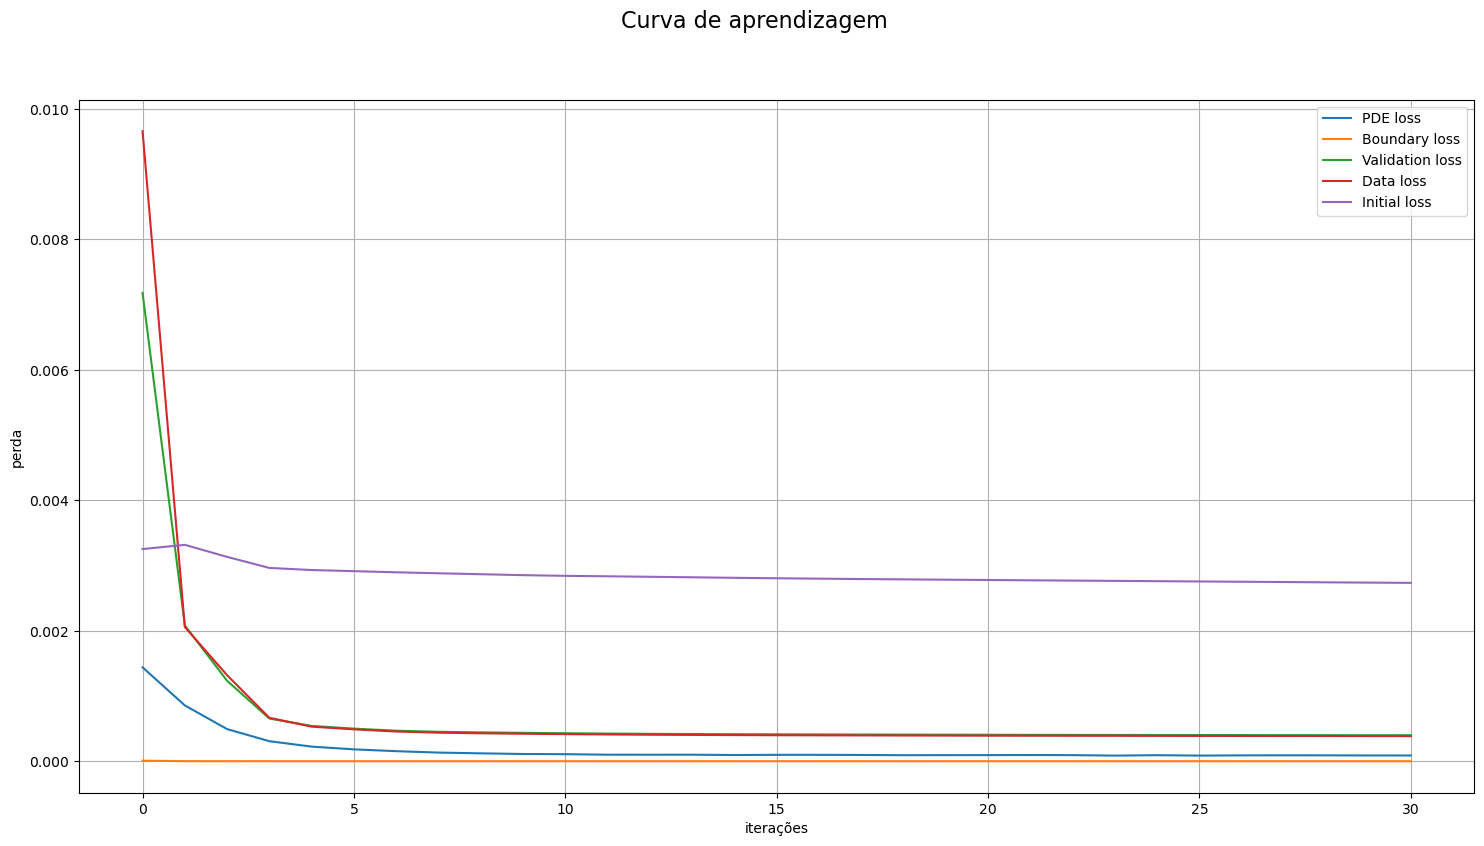

In [27]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(
    range(len(C_pde_loss_it.cpu().numpy())),
    C_pde_loss_it.cpu().numpy(),
    label="PDE loss",
)

ax.plot(
    range(len(C_boundary_loss_it.cpu().numpy())),
    C_boundary_loss_it.cpu().numpy(),
    label="Boundary loss",
)

ax.plot(
    range(len(val_loss_it.cpu().numpy())),
    val_loss_it.cpu().numpy(),
    label="Validation loss",
)

ax.plot(
    range(len(C_data_loss_it.cpu().numpy())),
    C_data_loss_it.cpu().numpy(),
    label="Data loss",
)

ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy(),
    label="Initial loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

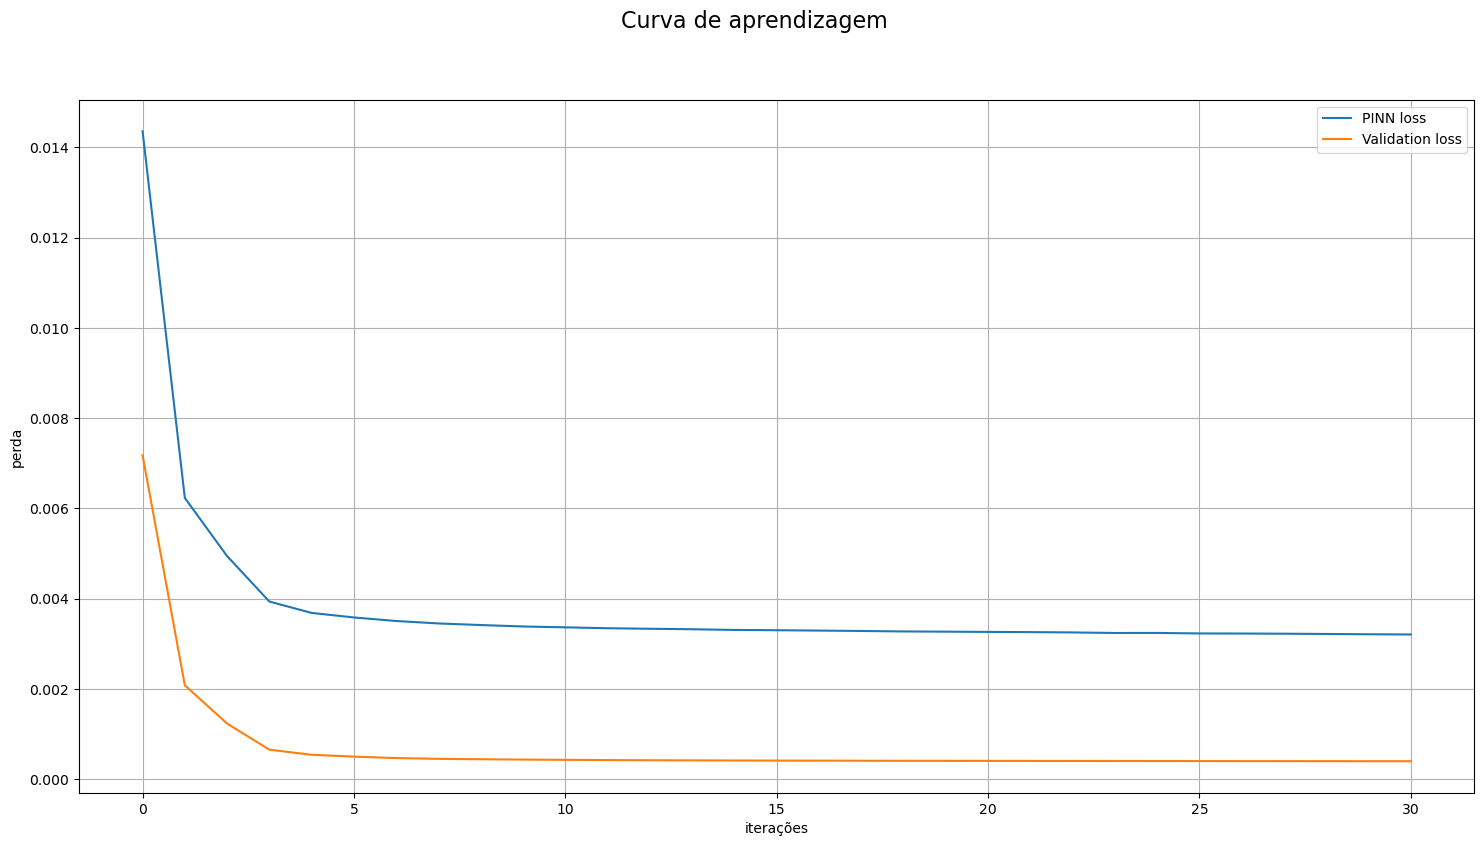

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy()
    + C_pde_loss_it.cpu().numpy()
    + C_boundary_loss_it.cpu().numpy()
    + C_data_loss_it.cpu().numpy(),
    label="PINN loss",
)
ax.plot(
    range(len(val_loss_it.cpu().numpy())),
    val_loss_it.cpu().numpy(),
    label="Validation loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

## Saving model weights and biases

In [29]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
0.weight 	 torch.Size([8, 3])
0.bias 	 torch.Size([8])
2.weight 	 torch.Size([32, 8])
2.bias 	 torch.Size([32])
4.weight 	 torch.Size([8, 32])
4.bias 	 torch.Size([8])
6.weight 	 torch.Size([32, 8])
6.bias 	 torch.Size([32])
8.weight 	 torch.Size([2, 32])
8.bias 	 torch.Size([2])


In [30]:
import os

pinn_file = "epochs_{}__batch_{}__arch_".format(n_epochs, batch_size) + arch_str

cwd = os.getcwd()

torch.save(model.state_dict(), cwd + "/nn_parameters/" + pinn_file + ".pt")

del model
del trainer

# Training setup

In [31]:
from pinn import *
import os

# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]
ini_cond_var = constant_properties["ini_cond_var"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]


Cn_list, Cb_list, speed_up_list = read_files("fvm_sim")

Cb_fvm, Cn_fvm, center_x_array, center_y_array, radius_array = format_array(
    Cb_list, Cn_list
)


reduced_Cb_fvm = under_sampling(1000, Cb_fvm)
reduced_Cn_fvm = under_sampling(1000, Cn_fvm)


simp_Cb_fvm = simplify_mx(reduced_Cb_fvm)
simp_Cn_fvm = simplify_mx(reduced_Cn_fvm)


size_x, size_y, size_t, initial_cond = get_mesh_properties(
    x_dom, y_dom, t_dom, h, k, central_ini_cond, ini_cond_var, Cb_fvm.shape[1]
)


(
    initial_tc,
    center_x_tc,
    center_y_tc,
    radius_tc,
    t_tc,
    x_tc,
    y_tc,
    target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    y_dom,
    simp_Cb_fvm.shape[0],
    size_x,
    size_y,
    center_x_array,
    center_y_array,
    initial_cond,
    radius_array,
    simp_Cb_fvm,
    simp_Cn_fvm,
)

arch_str =  "Elu--8__Elu--32__ReLU--8__ReLU--32"

model = generate_model(arch_str).to(device).apply(init_weights)


decay_rate = 0.95
n_epochs = 100
batch_size = 36000


trainer = train(
    n_epochs=n_epochs,
    batch_size=batch_size,
    decay_rate=decay_rate,
    model=model,
    initial_tc=initial_tc,
    center_x_tc=center_x_tc,
    center_y_tc=center_y_tc,
    radius_tc=radius_tc,
    t_tc=t_tc,
    x_tc=x_tc,
    y_tc=y_tc,
    target=target,
    device=device,
    n_points=batch_size,
    constant_properties=constant_properties,
    validation=0.1,
    tolerance=0.01,
    patience=10,
)


(
    model,
    C_pde_loss_it,
    C_boundary_loss_it,
    C_initial_loss_it,
    C_data_loss_it,
    val_loss_it,
) = trainer.execute()


# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

pinn_file = "epochs_{}__batch_{}__arch_".format(n_epochs, batch_size) + arch_str

cwd = os.getcwd()

torch.save(model.state_dict(), cwd + "/nn_parameters/" + pinn_file + ".pt")

with open("learning_curves/C_pde_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(
        C_pde_loss_it.cpu().numpy(),
        openfile
    )

with open("learning_curves/C_boundary_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(
        C_boundary_loss_it.cpu().numpy(),
        openfile
    )


with open("learning_curves/C_initial_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(
        C_initial_loss_it.cpu().numpy(),
        openfile
    )


with open("learning_curves/C_data_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(
        C_data_loss_it.cpu().numpy(),
        openfile
    )


with open("learning_curves/val_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(
        val_loss_it.cpu().numpy(),
        openfile
    )
    

del model
del trainer

Steps in time = 10001
Steps in space_x = 20
Steps in space_y = 20

device: cuda
Finished epoch 1, latest loss 0.1930638998746872, validation loss 0.012405529618263245
Finished epoch 10, latest loss 0.03413833677768707, validation loss 0.0003932812251150608
Finished epoch 20, latest loss 0.03240470960736275, validation loss 0.00033473558141849935
Early break!
Model's state_dict:
0.weight 	 torch.Size([8, 3])
0.bias 	 torch.Size([8])
2.weight 	 torch.Size([32, 8])
2.bias 	 torch.Size([32])
4.weight 	 torch.Size([8, 32])
4.bias 	 torch.Size([8])
6.weight 	 torch.Size([32, 8])
6.bias 	 torch.Size([32])
8.weight 	 torch.Size([2, 32])
8.bias 	 torch.Size([2])


# Evaluation setup

In [32]:
import os
from glob import glob


def load_model(file_name):
    cwd = os.getcwd()

    arch_str = (
        ("__")
        .join(file_name.split("/")[-1].split(".")[0].split("__")[2:])
        .split("arch_")[-1]
    )

    model = generate_model(arch_str).to(device)

    model.load_state_dict(torch.load(cwd + "/" + file_name, weights_only=True))

    print(model.eval())

    return model


nn_list = glob("nn_parameters/*")
nn_list = nn_list


model = load_model(nn_list[0])

Sequential(
  (0): Linear(in_features=3, out_features=8, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=8, out_features=32, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=32, out_features=8, bias=True)
  (5): ReLU()
  (6): Linear(in_features=8, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=2, bias=True)
)


In [33]:
def read_speed_ups(speed_up_list):
    speed_up_obj = {}
    for i,file in enumerate(speed_up_list):
        with open(file, "rb") as f:
            speed_up_obj[i] = pk.load(f)

    return speed_up_obj

In [35]:
speed_up_obj = read_speed_ups(speed_up_list)

output = {
    "mean_speed_up": [],
    "std_speed_up": 0,
    "mean_speed_comp_up": [],
    "std_speed_comp_up": 0,
    "mean_speed_up_pinn": [],
    "std_speed_up_pinn": 0,
    "mean_serial_time": [],
    "std_serial_time": 0,
    "mean_cuda_time": [],
    "std_cuda_time": 0,
    "mean_pinn_time": [],
    "std_pinn_time": 0,
}


error = np.zeros((len(speed_up_obj.keys()), len(target)))
target_np = target.cpu().detach().numpy()

for i in speed_up_obj.keys():

    start = time.time()

    mesh = torch.cat(
        [
            t_tc,
            x_tc,
            y_tc,
        ],
        dim=1,
    ).to(device)

    with torch.no_grad():
        pred_pinn_dev = model(mesh)

    pred_pinn = pred_pinn_dev.cpu().detach().numpy()

    end = time.time()

    pinn_time = end - start

    speed_up_obj[i]["pinn_time"] = pinn_time

    speed_up_obj[i]["speed_up_pinn"] = speed_up_obj[i]["serial_time"] / pinn_time

    output["mean_speed_up"].append(speed_up_obj[i]["speed_up"])
    
    output["mean_speed_comp_up"].append(speed_up_obj[i]["speed_comp_up"])
    
    output["mean_speed_up_pinn"].append(speed_up_obj[i]["speed_up_pinn"])
    
    output["mean_serial_time"].append(speed_up_obj[i]["serial_time"])
    
    output["mean_cuda_time"].append(speed_up_obj[i]["cuda_time"])
    
    output["mean_pinn_time"].append(speed_up_obj[i]["pinn_time"])

    aux = ((pred_pinn - target_np) ** 2) ** 0.5
    
    error[i] = aux[:, 0] + aux[:, 1]

In [36]:

output["std_speed_up"] = np.std(output["mean_speed_up"])
output["std_speed_up_pinn"] = np.std(output["mean_speed_up_pinn"])
output["std_serial_time"] = np.std(output["mean_serial_time"])
output["std_cuda_time"] = np.std(output["mean_cuda_time"])
output["std_pinn_time"] = np.std(output["mean_pinn_time"])

output["mean_speed_up"] = np.mean(output["mean_speed_up"])
output["mean_speed_up_pinn"] = np.mean(output["mean_speed_up_pinn"])
output["mean_serial_time"] = np.mean(output["mean_serial_time"])
output["mean_cuda_time"] = np.mean(output["mean_cuda_time"])
output["mean_pinn_time"] = np.mean(output["mean_pinn_time"])

rmse = np.mean(
    error.flatten()
)

max_ae = np.max(
   error.flatten()
)

output["pred_pinn"] = pred_pinn

In [37]:
print("Erro absoluto médio", rmse)
print("Erro absoluto máximo", max_ae)
print("Speed Up: {} +/-{}".format(output["mean_speed_up"], output["std_speed_up"]))
print(
    "Compilation Speed Up: {} +/-{}".format(
        output["mean_speed_comp_up"], output["std_speed_comp_up"]
    )
)
print(
    "PINN Speed Up: {} +/-{}".format(
        output["mean_speed_up_pinn"], output["std_speed_up_pinn"]
    )
)

Erro absoluto médio 0.019102255817134945
Erro absoluto máximo 0.3601422905921936
Speed Up: 990.1782504270511 +/-0.0
Compilation Speed Up: [403.5541897993333] +/-0
PINN Speed Up: 34864.90030019472 +/-0.0


# Printing simulations

In [38]:
Cl_pinn, Cp_pinn = pred_pinn_dev.cpu().detach().split(1, dim=1)

Cl_pinn_np = Cl_pinn.numpy().reshape(simp_Cb_fvm.shape)
Cp_pinn_np = Cp_pinn.numpy().reshape(simp_Cb_fvm.shape)


Cl_target, Cp_target = target.cpu().detach().split(1, dim=1)

Cl_target = Cl_target.numpy().reshape(simp_Cb_fvm.shape)
Cp_target = Cp_target.numpy().reshape(simp_Cb_fvm.shape)

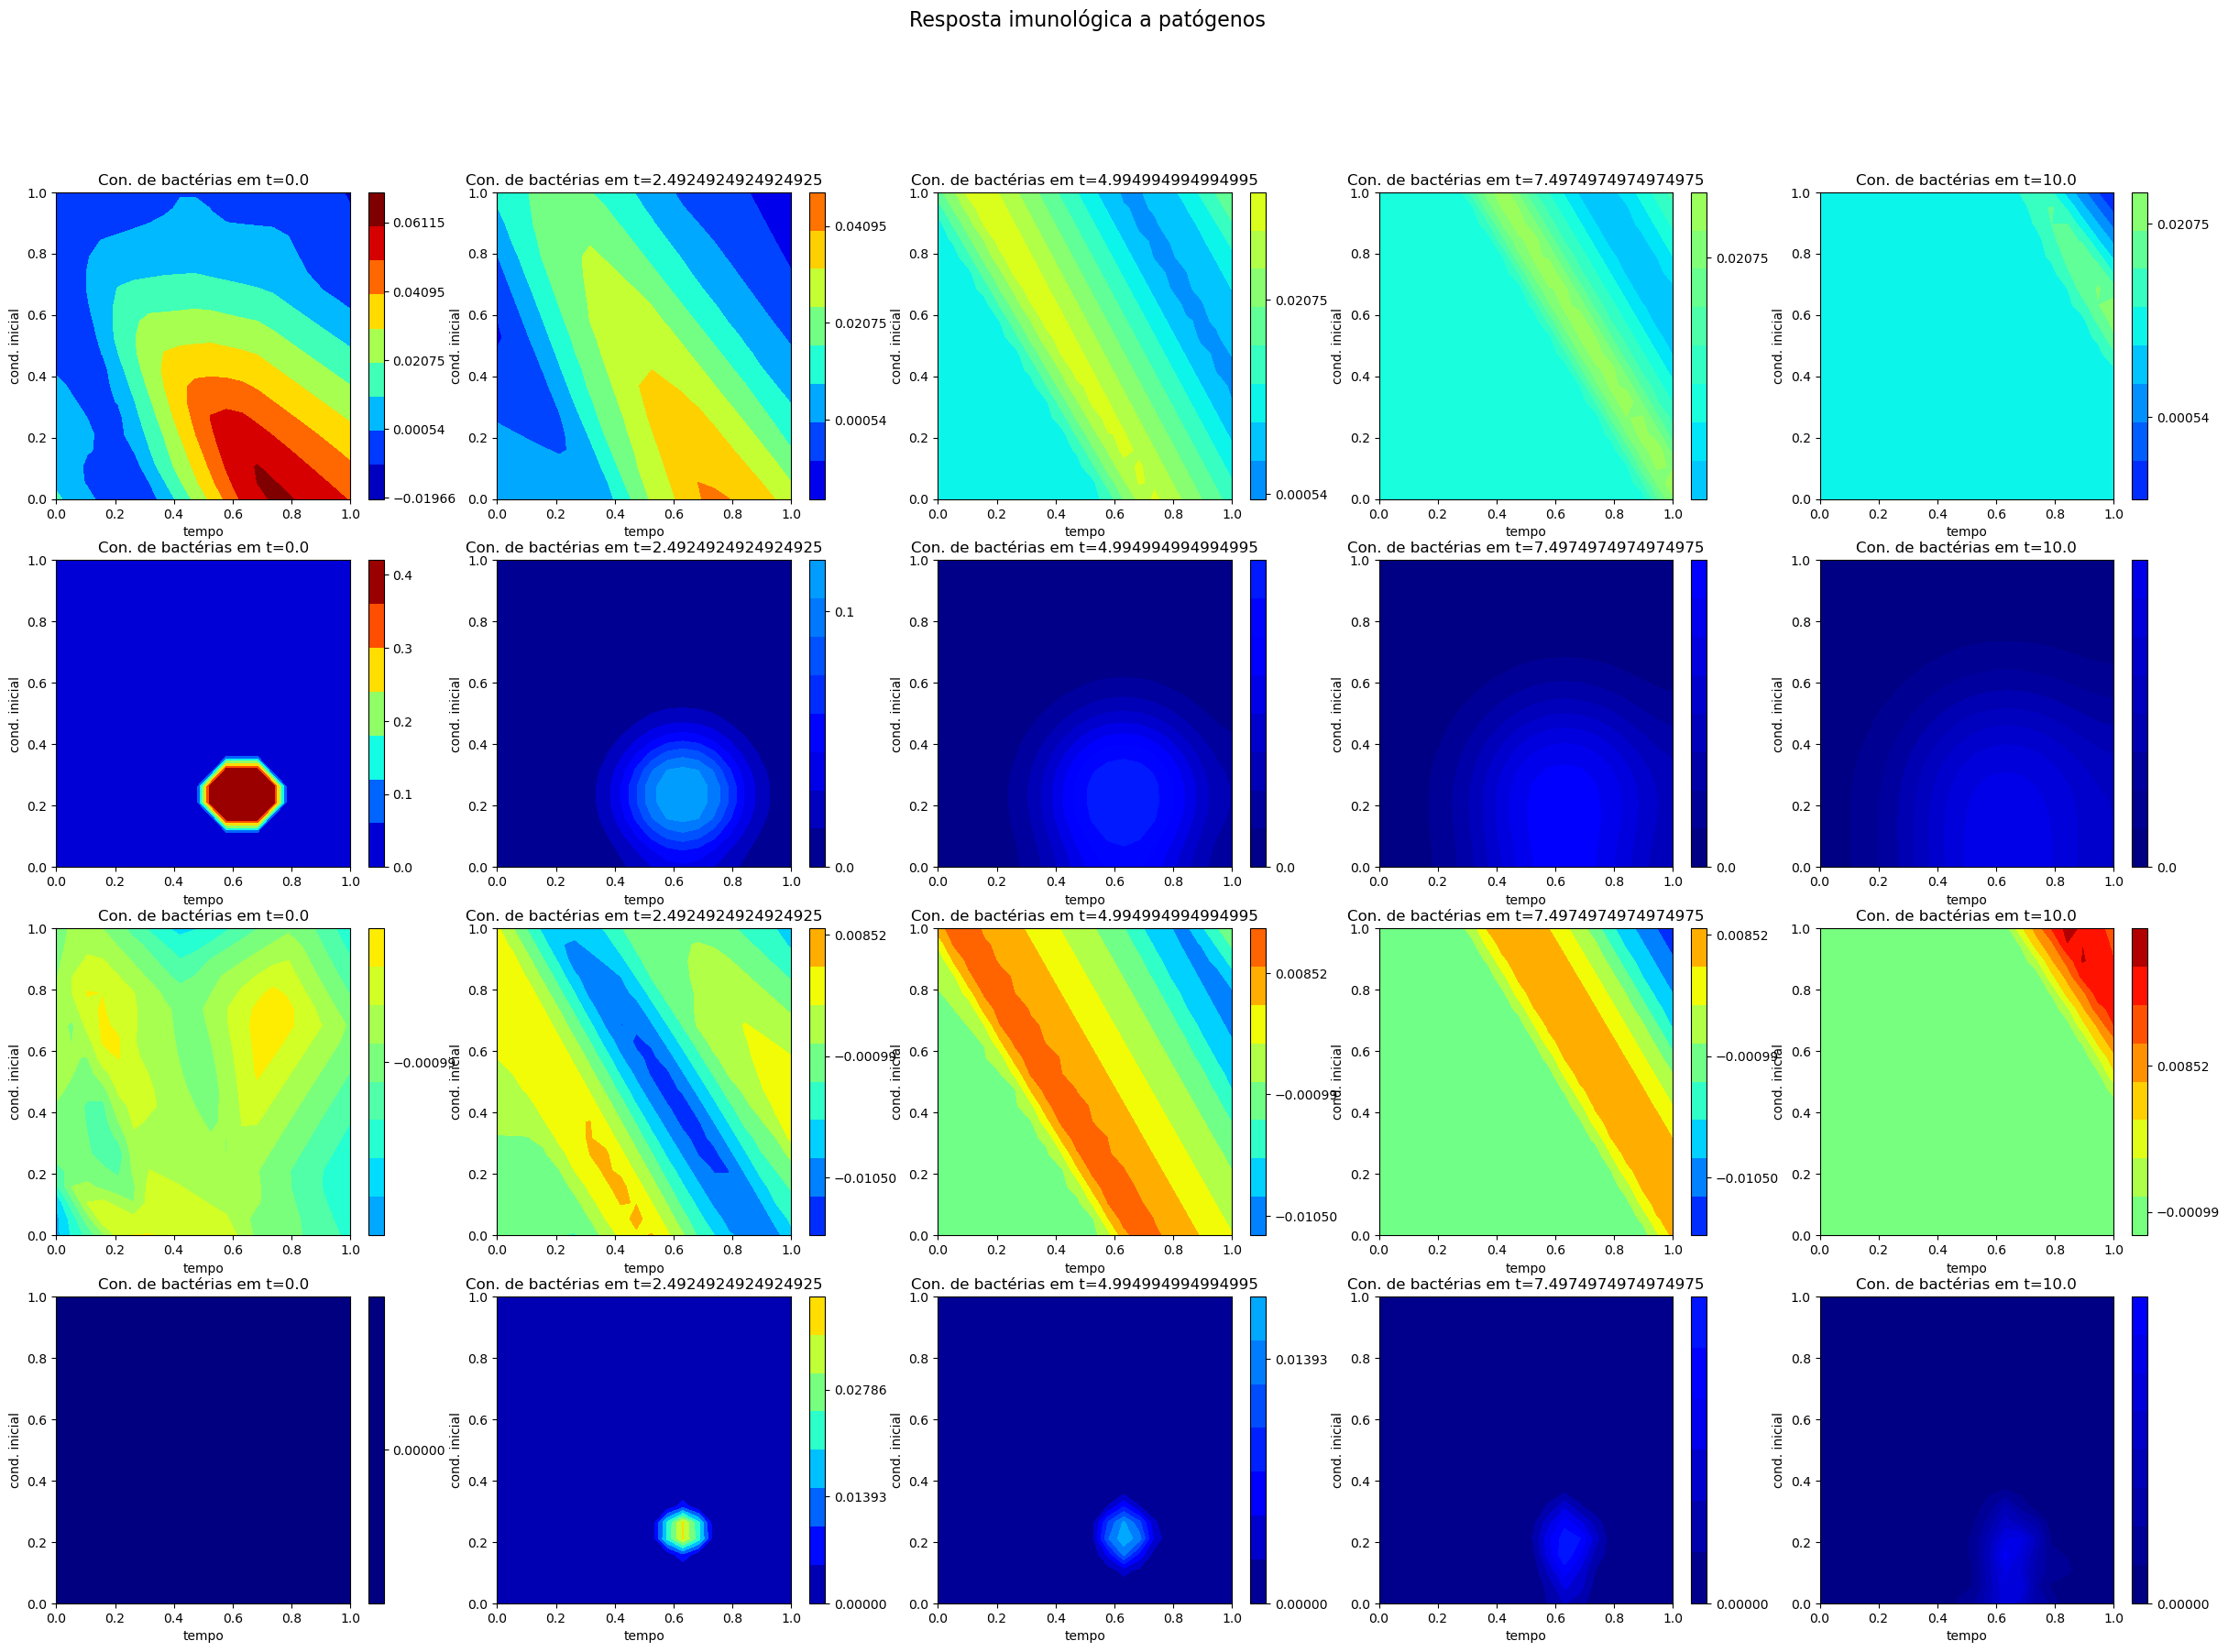

In [39]:
t = np.linspace(t_dom[0], t_dom[1], num=simp_Cb_fvm.shape[0], endpoint=True)
x = np.linspace(x_dom[0], x_dom[1], num=simp_Cb_fvm.shape[1], endpoint=True)
y = np.linspace(y_dom[0], y_dom[1], num=simp_Cb_fvm.shape[2], endpoint=True)

X, Y = np.meshgrid(x, y)

time_plot = np.linspace(0, len(t) - 1, num=5, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 20])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + 1)

    vmin = np.min(Cp_pinn_np)
    vmax = np.max(Cp_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cp_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))


for i, it in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) + 1)

    vmin = np.min(Cp_target)
    vmax = np.max(Cp_target)

    contour = ax.contourf(
        X,
        Y,
        Cp_target[it],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[it]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

    
for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 2 + 1)

    vmin = np.min(Cl_pinn_np)
    vmax = np.max(Cl_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cl_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))


for i, it in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 3 + 1)

    vmin = np.min(Cl_target)
    vmax = np.max(Cl_target)

    contour = ax.contourf(
        X,
        Y,
        Cl_target[it],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[it]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()